# 라이브러리 불러오기

In [145]:
# 기본 패키지 불러오기
import numpy as np
import pandas as pd
# !pip install holidays
import holidays

# 모델링을 위한 라이브러리
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# EDA 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기

In [146]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

print(train_df.shape)
print(test_df.shape)

(59397, 7)
(1092, 5)


In [147]:
display(train_df.head(3))
display(test_df.head(3))

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0


,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J


데이터 설명

train
    
- item : 품목 코드
    
    - TG : 감귤
    
    - BC : 브로콜리
    
    - RD : 무
    
    - CR : 당근
    
    - CB : 양배추
    
- corporation : 유통 법인 코드

    - A ~ F
    
- location : 지역 코드

    - J : 제주도 제주시 
    
    - S : 제주도 서귀포시
    
- supply(kg) : 유통된 물량

- price(원/kg) : 유통된 품목들의 kg마다의 가격
    
<br>
    
international_trads
    
- 관련 품목 수출입 정보
    
    - 중량 단위 kg
    
    - 금액 단위 천 달러

# 데이터 확인

In [148]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.2+ MB


In [149]:
train_df.describe()

,supply(kg),price(원/kg)
count,5.939700e+04,59397.000000
mean,1.189453e+04,1131.680674
std,5.226400e+04,2029.941445
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,0.000000e+00,0.000000
75%,3.800000e+03,1519.000000
max,1.222800e+06,20909.000000


In [150]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           1092 non-null   object
 1   timestamp    1092 non-null   object
 2   item         1092 non-null   object
 3   corporation  1092 non-null   object
 4   location     1092 non-null   object
dtypes: object(5)
memory usage: 42.8+ KB


<Axes: xlabel='item'>

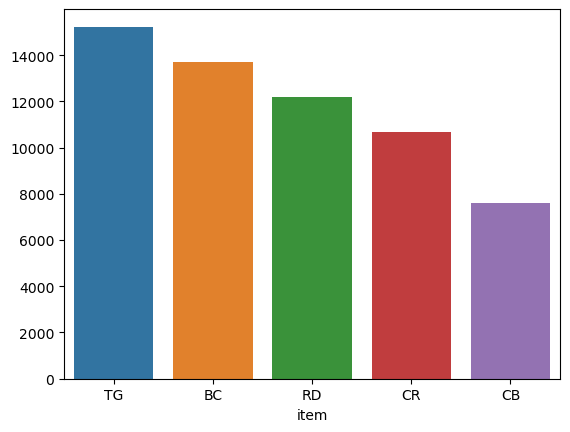

In [151]:
# 품목 비율
sns.barplot(x = train_df['item'].value_counts().index, y = train_df['item'].value_counts().values)

<Axes: xlabel='item', ylabel='value'>

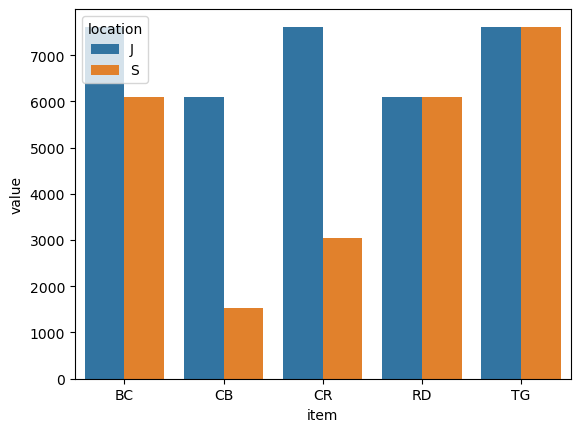

In [152]:
# 품목과 지역 비교

train_gb = train_df.groupby(['item', 'location']).size().reset_index()
train_gb = train_gb.rename(columns = {0 : 'value'})
sns.barplot(x = train_gb['item'], y = train_gb['value'], hue = train_gb['location'])

In [153]:
# 유통법인 비율

train_df['corporation'].value_counts()

corporation
A    13707
E    13707
D    12184
C     9138
B     7615
F     3046
Name: count, dtype: int64

<Axes: xlabel='corporation'>

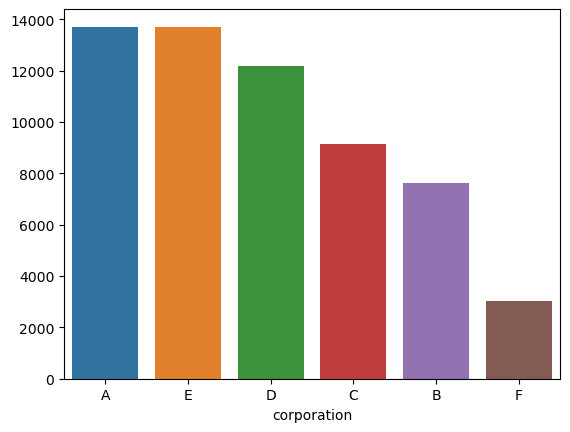

In [154]:
# 유통법인 비율

sns.barplot(x = train_df['corporation'].value_counts().index, y = train_df['corporation'].value_counts().values)

<Axes: xlabel='location'>

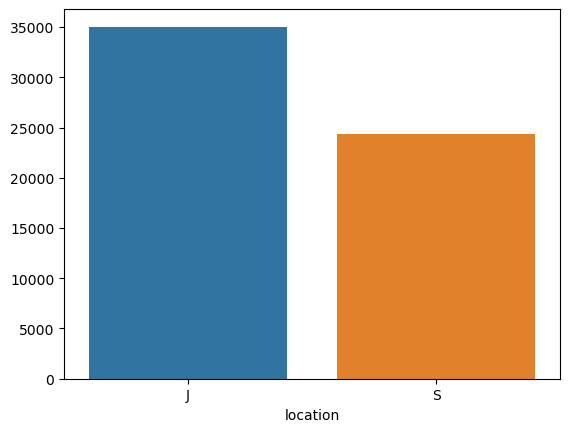

In [155]:
# 지역 비율

sns.barplot(x= train_df['location'].value_counts().index, y = train_df['location'].value_counts().values)

# 데이터 전처리

## 날짜 정보 추가

In [156]:
def add_day(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day    
    df['week'] = df['timestamp'].dt.weekday # 요일
    return df

In [157]:
train_df = add_day(train_df)
test_df = add_day(test_df)

display(train_df.head(2))
display(test_df.head(2))

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,week
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2


,ID,timestamp,item,corporation,location,year,month,day,week
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,3,4,5
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,3,5,6


In [158]:
supply_no = train_df[train_df['supply(kg)'] == 0.0] 

supply_no

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,week
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2
5,TG_A_J_20190106,2019-01-06,TG,A,J,0.0,0.0,2019,1,6,6
12,TG_A_J_20190113,2019-01-13,TG,A,J,0.0,0.0,2019,1,13,6
19,TG_A_J_20190120,2019-01-20,TG,A,J,0.0,0.0,2019,1,20,6
...,...,...,...,...,...,...,...,...,...,...,...
59363,RD_F_J_20230129,2023-01-29,RD,F,J,0.0,0.0,2023,1,29,6
59370,RD_F_J_20230205,2023-02-05,RD,F,J,0.0,0.0,2023,2,5,6
59377,RD_F_J_20230212,2023-02-12,RD,F,J,0.0,0.0,2023,2,12,6
59384,RD_F_J_20230219,2023-02-19,RD,F,J,0.0,0.0,2023,2,19,6


In [159]:
supply_no_year = supply_no.groupby(['year']).size()
supply_no_month = supply_no.groupby(['month']).size()
supply_no_day = supply_no.groupby(['day']).size()
supply_no_week = supply_no.groupby(['week']).size()

print(supply_no_year)
print(supply_no_month)
print(supply_no_day)
print(supply_no_week)

year
2019    8820
2020    8824
2021    8449
2022    8362
2023     997
dtype: int64
month
1     2491
2     2127
3     1725
4     2181
5     3067
6     3454
7     3795
8     3851
9     3767
10    3717
11    2954
12    2323
dtype: int64
day
1     1303
2     1274
3     1237
4     1096
5     1158
6     1216
7     1159
8     1124
9     1109
10    1161
11    1105
12    1207
13    1215
14    1152
15    1143
16    1115
17    1162
18    1077
19    1161
20    1171
21    1144
22    1153
23    1144
24    1211
25    1139
26    1166
27    1199
28    1129
29    1108
30    1007
31     707
dtype: int64
week
0    4388
1    4435
2    4447
3    4468
4    4451
5    4821
6    8442
dtype: int64


=> 일요일(6)은 확실히 공급량이 적다

In [160]:
display(train_df[(train_df['week'] == 6) & (train_df['supply(kg)'] != 0)])
print(len(train_df[(train_df['week'] == 6) & (train_df['supply(kg)'] != 0)]))

ind = train_df[(train_df['week'] == 6) & (train_df['supply(kg)'] != 0)].index

print(ind)

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,week
1125,TG_A_J_20220130,2022-01-30,TG,A,J,43455.0,1597.0,2022,1,30,6
2648,TG_A_S_20220130,2022-01-30,TG,A,S,38439.0,2341.0,2022,1,30,6
4171,TG_B_J_20220130,2022-01-30,TG,B,J,3294.0,2213.0,2022,1,30,6
5694,TG_B_S_20220130,2022-01-30,TG,B,S,80659.0,1965.0,2022,1,30,6
7217,TG_C_J_20220130,2022-01-30,TG,C,J,51458.4,2755.0,2022,1,30,6
8740,TG_C_S_20220130,2022-01-30,TG,C,S,29426.0,2769.0,2022,1,30,6
10263,TG_D_J_20220130,2022-01-30,TG,D,J,13505.0,1625.0,2022,1,30,6
11786,TG_D_S_20220130,2022-01-30,TG,D,S,5825.0,1604.0,2022,1,30,6
13309,TG_E_J_20220130,2022-01-30,TG,E,J,12705.0,2396.0,2022,1,30,6
14832,TG_E_S_20220130,2022-01-30,TG,E,S,20073.0,1875.0,2022,1,30,6


21
Index([ 1125,  2648,  4171,  5694,  7217,  8740, 10263, 11786, 13309, 14832,
       27016, 33108, 34631, 37677, 39200, 40723, 43769, 49861, 52907, 54430,
       58999],
      dtype='int64')


=> 2022년 1월 30일은 일요일인데 공급량이 있다

1월 31일이 설날이라 열었나?? -> 데이터를 삭제할지 요일을 없는 값으로 변경할지 고민

In [161]:
# 2022년 1월 30일 데이터의 요일을 다르 값으로 변경

for i in range(len(train_df)):
    if i in ind:
        train_df.loc[i, 'week'] = 7

In [162]:
display(train_df[train_df['week'] == 7])
print(len(train_df[train_df['week'] == 7]))

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,week
1125,TG_A_J_20220130,2022-01-30,TG,A,J,43455.0,1597.0,2022,1,30,7
2648,TG_A_S_20220130,2022-01-30,TG,A,S,38439.0,2341.0,2022,1,30,7
4171,TG_B_J_20220130,2022-01-30,TG,B,J,3294.0,2213.0,2022,1,30,7
5694,TG_B_S_20220130,2022-01-30,TG,B,S,80659.0,1965.0,2022,1,30,7
7217,TG_C_J_20220130,2022-01-30,TG,C,J,51458.4,2755.0,2022,1,30,7
8740,TG_C_S_20220130,2022-01-30,TG,C,S,29426.0,2769.0,2022,1,30,7
10263,TG_D_J_20220130,2022-01-30,TG,D,J,13505.0,1625.0,2022,1,30,7
11786,TG_D_S_20220130,2022-01-30,TG,D,S,5825.0,1604.0,2022,1,30,7
13309,TG_E_J_20220130,2022-01-30,TG,E,J,12705.0,2396.0,2022,1,30,7
14832,TG_E_S_20220130,2022-01-30,TG,E,S,20073.0,1875.0,2022,1,30,7


21


## 휴일 정보 추가

=> 일요일은 휴일로 안 들어감

In [163]:
# 휴일col 추가

def holiday(x):
    holiday = holidays.KR()
    
    if x in holiday:
        return 1
    else:
        return 0

In [164]:
train_df['holiday'] = train_df['timestamp'].map(lambda x : holiday(x))

In [165]:
train_df['holiday'].value_counts()

holiday
0    56394
1     3003
Name: count, dtype: int64

In [166]:
test_df['holiday'] = test_df['timestamp'].map(lambda x : holiday(x))

test_df['holiday'].value_counts()

holiday
0    1092
Name: count, dtype: int64

## 이상치 처리

In [167]:
# item별 이상치 확인

train_df.groupby('item')['price(원/kg)'].describe()

,count,mean,std,min,25%,50%,75%,max
item,,,,,,,,
BC,13707.0,910.196615,1422.148301,0.0,0.00,0.0,2032.50,8750.0
CB,7615.0,152.187131,345.053036,0.0,0.00,0.0,0.00,2500.0
CR,10661.0,273.118938,632.929933,0.0,0.00,0.0,0.00,3882.0
RD,12184.0,187.073539,358.150266,0.0,0.00,0.0,383.00,5715.0
TG,15230.0,3177.442022,2805.240092,0.0,992.25,2273.5,5532.75,20909.0


=> TG가 이상

In [168]:
# 이상치 제거
# 각 품목에 대해 훈련 데이터에서 가격의 사분위수를 계산하여 딕셔너리에 저장

item_dic = {'BC' : 0, 'CB' : 0, 'CR' : 0, 'RD' : 0, 'TG' : 0}
item_dic = {it : train_df[train_df['item'] == it]['price(원/kg)'].quantile(0.95) for it in item_dic.keys()}
    
print(item_dic)

{'BC': 3848.399999999998, 'CB': 1000.0, 'CR': 1676.0, 'RD': 666.8500000000004, 'TG': 8000.0}


In [169]:
for i in range(len(train_df)):
    item = train_df.loc[i, 'item']
    
    if train_df.loc[i, 'price(원/kg)'] > item_dic[item]:
        train_df.loc[i, 'price(원/kg)'] = item_dic[item]

In [170]:
train_df.groupby('item')['price(원/kg)'].describe()

,count,mean,std,min,25%,50%,75%,max
item,,,,,,,,
BC,13707.0,872.613657,1322.976898,0.0,0.00,0.0,2032.50,3848.40
CB,7615.0,138.160735,294.697344,0.0,0.00,0.0,0.00,1000.00
CR,10661.0,237.043617,505.307581,0.0,0.00,0.0,0.00,1676.00
RD,12184.0,159.222546,236.759476,0.0,0.00,0.0,383.00,666.85
TG,15230.0,3109.188378,2650.214809,0.0,992.25,2273.5,5532.75,8000.00


## 이상값 제거

공급량이 없는데 가격이 0이 아니거나 공급량이 있는데 가격이 0인 경우 제거

In [171]:
train_df[(train_df['supply(kg)'] == 0) & train_df['price(원/kg)'] != 0]

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,week,holiday


In [172]:
drop_ind = train_df[(train_df['price(원/kg)'] == 0) & (train_df['supply(kg)'])].index
print(drop_ind)
print(train_df.shape)

train_df = train_df.drop(drop_ind)
train_df = train_df.reset_index(drop = True)

print(train_df.shape)

Index([825, 9266, 31199], dtype='int64')
(59397, 12)
(59394, 12)


## 범주형 -> 수치형

In [173]:
# 필요없는 col제거

test_id = test_df['ID'] # 결과 제출할 때 필요

train_df = train_df.drop(['ID', 'timestamp', 'supply(kg)'], axis = 1)
test_df = test_df.drop(['ID', 'timestamp'], axis = 1)

In [174]:
cat_col = ['item', 'corporation', 'location']

for col in cat_col:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col]) # test데이터에는 fit을 하지 않는다

/Users/yurim/anaconda3/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.draw()
/Users/yurim/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  func(*args, **kwargs)
/Users/yurim/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


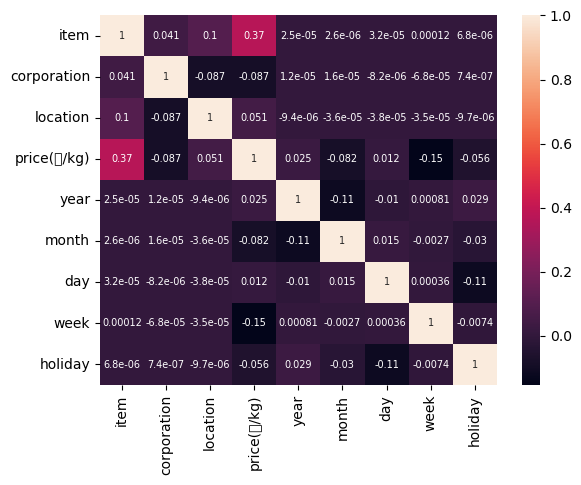

In [175]:
sns.heatmap(train_df.corr(), annot=True, annot_kws={"size": 7});

# 모델링

In [176]:
y = train_df['price(원/kg)']
X = train_df.drop('price(원/kg)', axis = 1)

In [177]:
# 데이터 세트 나누기

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(41575, 8) (17819, 8) (41575,) (17819,)


## RandomForest

In [178]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

rf_pred_tr = rf.predict(X_train) # 학습용 데이터셋의 타깃 변수 예측
rf_pred_tr = np.where(rf_pred_tr < 0, 0, rf_pred_tr) # 예측값이 -인 경우 0으로 처리
rf_pred_te = rf.predict(X_test) # 검증용 데이터셋의 타깃 변수 예측
rf_pred_te = np.where(rf_pred_te < 0, 0, rf_pred_te) # 예측값이 -인 경우 0으로 처리

In [179]:
# rmse

rf_rmse_tr = mean_squared_error(y_train, rf_pred_tr, squared = False) # 학습 데이터셋의 rmse
rf_rmse_te = mean_squared_error(y_test, rf_pred_te, squared = False) # 검증 데이터셋의 rmse

print('train rmse : {:.4f}'.format(rf_rmse_tr))
print('test rmse : {:.4f}'.format(rf_rmse_te))

train rmse : 293.0795
test rmse : 774.3804


## XGBoost

In [180]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

xgb_pred_tr = xgb.predict(X_train)
xgb_pred_tr = np.where(xgb_pred_tr < 0, 0, xgb_pred_tr) # 예측값이 -인 경우 0으로 처리
xgb_pred_te = xgb.predict(X_test)
xgb_pred_te = np.where(xgb_pred_te < 0, 0, xgb_pred_te) # 예측값이 -인 경우 0으로 처리

In [181]:
# rmse

xgb_rmse_tr = mean_squared_error(y_train, xgb_pred_tr, squared = False) # 학습 데이터셋의 rmse
xgb_rmse_te = mean_squared_error(y_test, xgb_pred_te, squared = False) # 검증 데이터셋의 rmse

print('train rmse : {:.4f}'.format(xgb_rmse_tr))
print('test rmse : {:.4f}'.format(xgb_rmse_te))

train rmse : 719.0589
test rmse : 790.9050


# 그리드서치

## RandomForest

In [ ]:
rf = RandomForestRegressor()

params = {
    'n_estimators': [200, 300, 400],  # 트리의 개수
    'max_features': ['auto', 'sqrt'],  # 각 노드에서 feature를 찾는 방법
    'max_depth': [5, 10, 20, 30, None],  # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],  # 노드를 분할하기 위한 최소한의 샘플 수
    'min_samples_leaf': [1, 2, 4],  # 리프 노드가 되기 위한 최소한의 샘플 수
    'bootstrap': [True, False]  # 샘플링 시 중복 허용 여부
}

# 교차 검증
kf = KFold(random_state = 30,
           n_splits = 10,
           shuffle = True)

rf_grid = GridSearchCV(estimator = rf,
                    param_grid = params,
                    cv = kf,
                    scoring = 'neg_root_mean_squared_error', 
                    n_jobs = -1)

In [183]:
rf_grid.fit(X_train, y_train)

/Users/yurim/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print('최적 하이퍼파라미터:', rf_grid.best_params_)
print('최적 평균 RMSE:', -rf_grid.best_score_)

In [ ]:
rf_g = RandomForestRegressor()
rf_g.fit(X_train, y_train)

rf_pred_tr = rf_g.predict(X_train) # 학습용 데이터셋의 타깃 변수 예측
rf_pred_tr = np.where(rf_pred_tr < 0, 0, rf_pred_tr) # 예측값이 -인 경우 0으로 처리
rf_pred_te = rf_g.predict(X_test) # 검증용 데이터셋의 타깃 변수 예측
rf_pred_te = np.where(rf_pred_te < 0, 0, rf_pred_te) # 예측값이 -인 경우 0으로 처리

# rmse

rf_rmse_tr = mean_squared_error(y_train, rf_pred_tr, squared = False) # 학습 데이터셋의 rmse
rf_rmse_te = mean_squared_error(y_test, rf_pred_te, squared = False) # 검증 데이터셋의 rmse

print('train rmse : {:.4f}'.format(rf_rmse_tr))
print('test rmse : {:.4f}'.format(rf_rmse_te))

## XGBoost

In [ ]:
xgb_model = XGBRegressor()

# 하이퍼파라미터 그리드 설정
params = {
    'n_estimators': [100, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

kf = KFold(random_state = 30,
           n_splits = 10,
           shuffle = True)

# 그리드 서치 수행
xgb_grid = GridSearchCV(estimator = xgb_model,
                        param_grid = params,
                        scoring='neg_root_mean_squared_error',
                        cv = kf)

xgb_grid.fit(X_train, y_train)

# 최적의 파라미터와 RMSE 값 출력
print('최적 하이퍼파라미터:', xgb_grid.best_params_)
print('최적 평균 RMSE:', -xgb_grid.best_score_)

In [ ]:
xgb_g = XGBRegressor()
xgb_g.fit(X_train, y_train)

xgb_pred_tr = xgb_g.predict(X_train)
xgb_pred_tr = np.where(xgb_pred_tr < 0, 0, xgb_pred_tr) # 예측값이 -인 경우 0으로 처리
xgb_pred_te = xgb_g.predict(X_test)
xgb_pred_te = np.where(xgb_pred_te < 0, 0, xgb_pred_te) # 예측값이 -인 경우 0으로 처리

# rmse

xgb_rmse_tr = mean_squared_error(y_train, xgb_pred_tr, squared = False) # 학습 데이터셋의 rmse
xgb_rmse_te = mean_squared_error(y_test, xgb_pred_te, squared = False) # 검증 데이터셋의 rmse

print('train rmse : {:.4f}'.format(xgb_rmse_tr))
print('test rmse : {:.4f}'.format(xgb_rmse_te))

# 결과 저장

In [185]:
xgb_pred_res = xgb.predict(test_df)
xgb_pred_res = np.where(xgb_pred_res < 0, 0, xgb_pred_res) # 예측값이 -인 경우 0으로 처리

In [187]:
submission = pd.DataFrame({'ID' : test_id, 'price' : xgb_pred_res})
submission

,ID,price
0,TG_A_J_20230304,2478.700928
1,TG_A_J_20230305,0.000000
2,TG_A_J_20230306,3243.188965
3,TG_A_J_20230307,3525.765381
4,TG_A_J_20230308,3828.539551
...,...,...
1087,RD_F_J_20230327,456.082855
1088,RD_F_J_20230328,402.630127
1089,RD_F_J_20230329,389.167694
1090,RD_F_J_20230330,581.263733
